In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
import xgcm
from xgcm.autogenerate import generate_grid_ds

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

# Read data

In [3]:
LLC_data_folder = '/meddy/yuxlong5/data/LLC4320_SCS/llc_raw/'
ds = xr.open_zarr(LLC_data_folder+'llc_0.zarr').drop(['Depth','CS','SN','PHrefC','PHrefF','rAw','rAs','rAz','niter','rA','k_l','k_p1','k_u','Z','Zl','Zp1','Zu','drC','drF'])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (time: 2147, j: 1501, i: 1501, i_g: 1501, j_g: 1501, k: 90)
Coordinates: (12/14)
    XC       (j, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    ...       ...
  * i        (i) int64 6500 6501 6502 6503 6504 ... 7996 7997 7998 7999 8000
  * i_g      (i_g) int64 6500 6501 6502 6503 6504 ... 7996 7997 7998 7999 8000
  * j        (j) int64 8000 8001 8002 8003 8004 ... 9496 9497 9498 9499 9500
  * j_g      (j_g) int64 8000 8001 8002 8003 8004 ... 9496 9497 9498 9499 9500
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85

In [4]:
lon = np.array(ds.XC.isel(j=1), dtype='>f')
lon

array([ 97.427086,  97.447914,  97.46875 , ..., 128.63542 , 128.65625 ,
       128.67708 ], dtype='>f4')

In [5]:
lon_g = np.array(ds.XG.isel(j_g=1), dtype='>f')
lon_g

array([ 97.416664,  97.4375  ,  97.458336, ..., 128.625   , 128.64583 ,
       128.66667 ], dtype='>f4')

In [6]:
lat = np.array(ds.YC.isel(i=1), dtype='>f')
lat

array([ 1.5575294,  1.5768595,  1.5961889, ..., 28.996317 , 29.013075 ,
       29.02983  ], dtype='>f4')

In [7]:
lat_g = np.array(ds.YG.isel(i_g=1), dtype='>f')
lat_g

array([ 1.5478642,  1.5671945,  1.5865242, ..., 28.987936 , 29.004696 ,
       29.021454 ], dtype='>f4')

In [8]:
ds = ds.assign_coords(j=lat) 
ds = ds.assign_coords(i=lon) 
ds = ds.assign_coords(j_g=lat_g) 
ds = ds.assign_coords(i_g=lon_g) 
ds = ds.drop(['k'])
ds

<xarray.Dataset>
Dimensions:  (time: 2147, j: 1501, i: 1501, i_g: 1501, j_g: 1501)
Coordinates: (12/13)
    XC       (j, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    ...       ...
    dyG      (j, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * i_g      (i_g) >f4 97.42 97.44 97.46 97.48 97.5 ... 128.6 128.6 128.6 128.7
  * j        (j) >f4 1.558 1.577 1.596 1.616 1.635 ... 28.98 29.0 29.01 29.03
  * j_g      (j_g) >f4 1.548 1.567 1.587 1.606 1.625 ... 28.97 28.99 29.0 29.02
  * time     (time) datetime64[ns] 2011-11-23T08:00:00 ... 2012-02-20T18:00:00
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    KPPhbl   (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SST      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSU      (time, j, i_g) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSV      (time, j_g, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    oceTAUX  (time, j, i_g) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    oceTAUY  (time, j_g, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>

____________
## Daily

In [9]:
ds_daily = ds.resample(time='D').mean()
ds_daily

<xarray.Dataset>
Dimensions:  (time: 90, j: 1501, i: 1501, i_g: 1501, j_g: 1501)
Coordinates: (12/13)
    XC       (j, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
    ...       ...
    dyG      (j, i_g) float32 dask.array<chunksize=(1501, 1501), meta=np.ndarray>
  * i        (i) >f4 97.43 97.45 97.47 97.49 97.51 ... 128.6 128.6 128.7 128.7
  * i_g      (i_g) >f4 97.42 97.44 97.46 97.48 97.5 ... 128.6 128.6 128.6 128.7
  * j        (j) >f4 1.558 1.577 1.596 1.616 1.635 ... 28.98 29.0 29.01 29.03
  * j_g      (j_g) >f4 1.548 1.567 1.587 1.606 1.625 ... 28.97 28.99 29.0 29.02
  * time     (time) datetime64[ns] 2011-11-23 2011-11-24 ... 2012-02-20
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    KPPhbl   (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SST      (time, j, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSU      (time, j, i_g) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    SSV      (time, j_g, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    oceTAUX  (time, j, i_g) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>
    oceTAUY  (time, j_g, i) float32 dask.array<chunksize=(1, 1501, 1501), meta=np.ndarray>

In [12]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'i', 'left':'i_g'},
                              'Y':{'center':'j', 'left':'j_g'}}, 
                              periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center


In [13]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')

In [14]:
du_dx = gridx.diff(ds.SSU, 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(ds.SSV, 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(ds.SSU, 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(ds.SSV, 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

In [15]:
zeta = dv_dx - du_dy
div  = du_dx + dv_dy

normal_strain = du_dx - dv_dy
shear_strain = dv_dx + du_dy
strain_rate = (normal_strain**2 + shear_strain**2)**0.5

zeta_f = zeta/f_ij
div_f = div/f_ij
strain_rate_f = strain_rate/f_ij

In [16]:
gridx_daily = xgcm.Grid(ds_daily, coords={'X':{'center':'i', 'left':'i_g'},
                                          'Y':{'center':'j', 'left':'j_g'}}, 
                                          periodic=['X', 'Y'])
print(gridx_daily)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center


In [20]:
du_dx_daily = gridx_daily.diff(ds_daily.SSU, 'X')/gridx_daily.interp(ds_daily.dxG, 'Y')
dv_dy_daily = gridx_daily.diff(ds_daily.SSV, 'Y')/gridx_daily.interp(ds_daily.dyG, 'X')

In [23]:
du_dy_daily = gridx_daily.interp(gridx_daily.interp(gridx_daily.diff(ds_daily.SSU, 'Y')/gridx_daily.interp(ds_daily.dyC, 'X'), 'X'), 'Y')
dv_dx_daily = gridx_daily.interp(gridx_daily.interp(gridx_daily.diff(ds_daily.SSV, 'X')/gridx_daily.interp(ds_daily.dxC, 'Y'), 'X'), 'Y')

In [24]:
zeta_daily = dv_dx_daily - du_dy_daily
div_daily  = du_dx_daily + dv_dy_daily

normal_strain_daily = du_dx_daily - dv_dy_daily
shear_strain_daily = dv_dx_daily + du_dy_daily
strain_rate_daily = (normal_strain_daily**2 + shear_strain_daily**2)**0.5

zeta_f_daily = zeta_daily/f_ij
div_f_daily = div_daily/f_ij
strain_rate_f_daily = strain_rate_daily/f_ij

## Figure

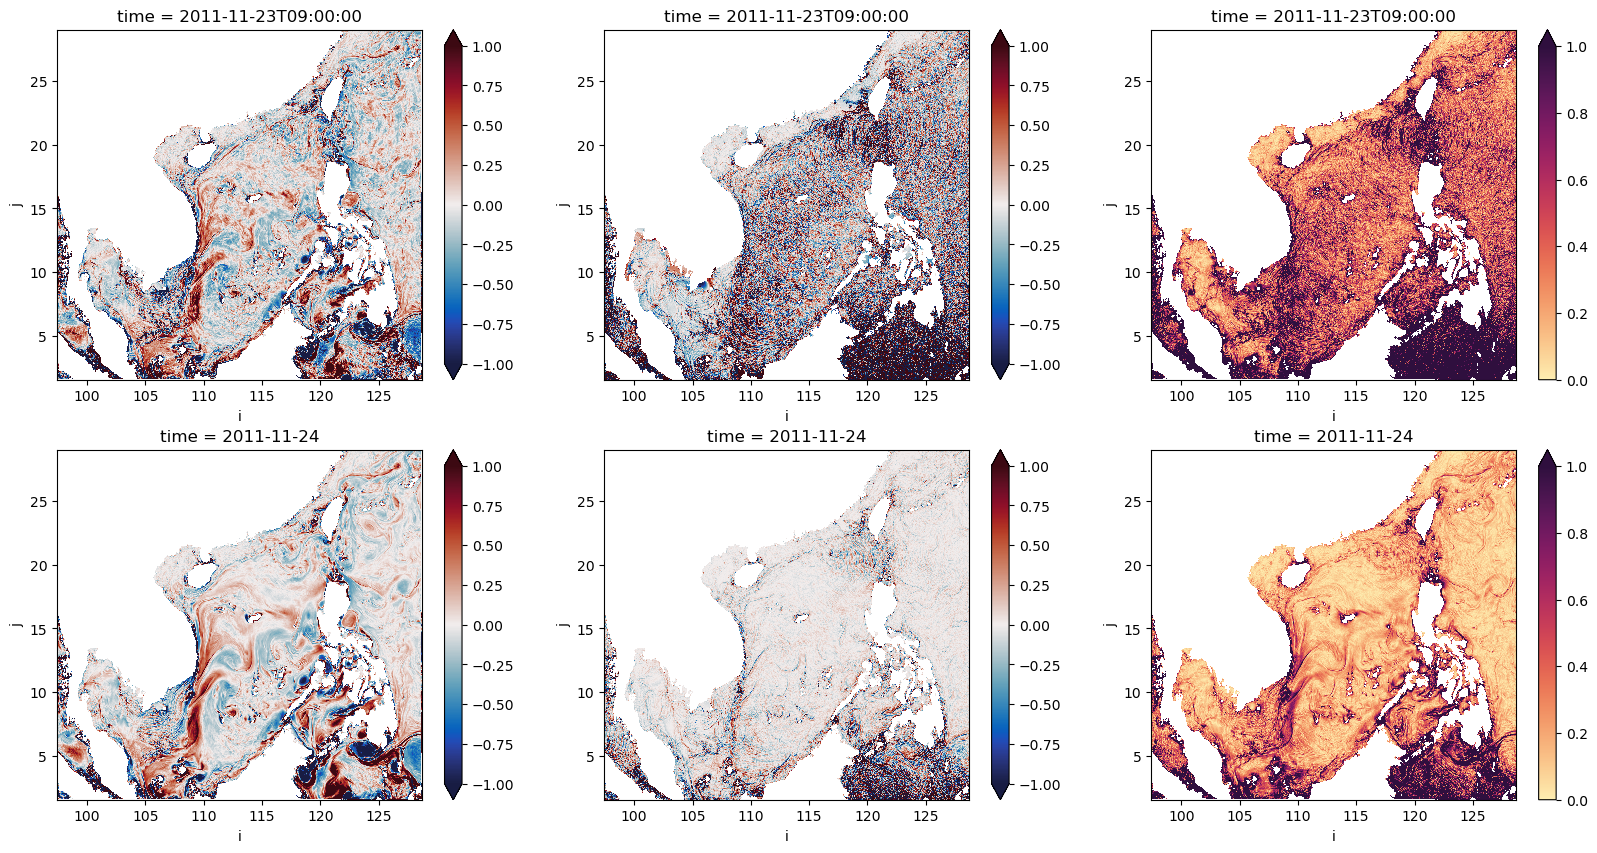

In [27]:
fig = plt.figure(figsize=(20,10))

plt.subplot(231)
zeta_f.isel(time=1).plot(vmax=1,vmin=-1, cmap=cm.balance)

plt.subplot(232)
div_f.isel(time=1).plot(vmax=1,vmin=-1, cmap=cm.balance)

plt.subplot(233)
strain_rate_f.isel(time=1).plot(vmax=1,vmin=0, cmap=cm.matter)

plt.subplot(234)
zeta_f_daily.isel(time=1).plot(vmax=1,vmin=-1, cmap=cm.balance)

plt.subplot(235)
div_f_daily.isel(time=1).plot(vmax=1,vmin=-1, cmap=cm.balance)

plt.subplot(236)
strain_rate_f_daily.isel(time=1).plot(vmax=1,vmin=0, cmap=cm.matter)

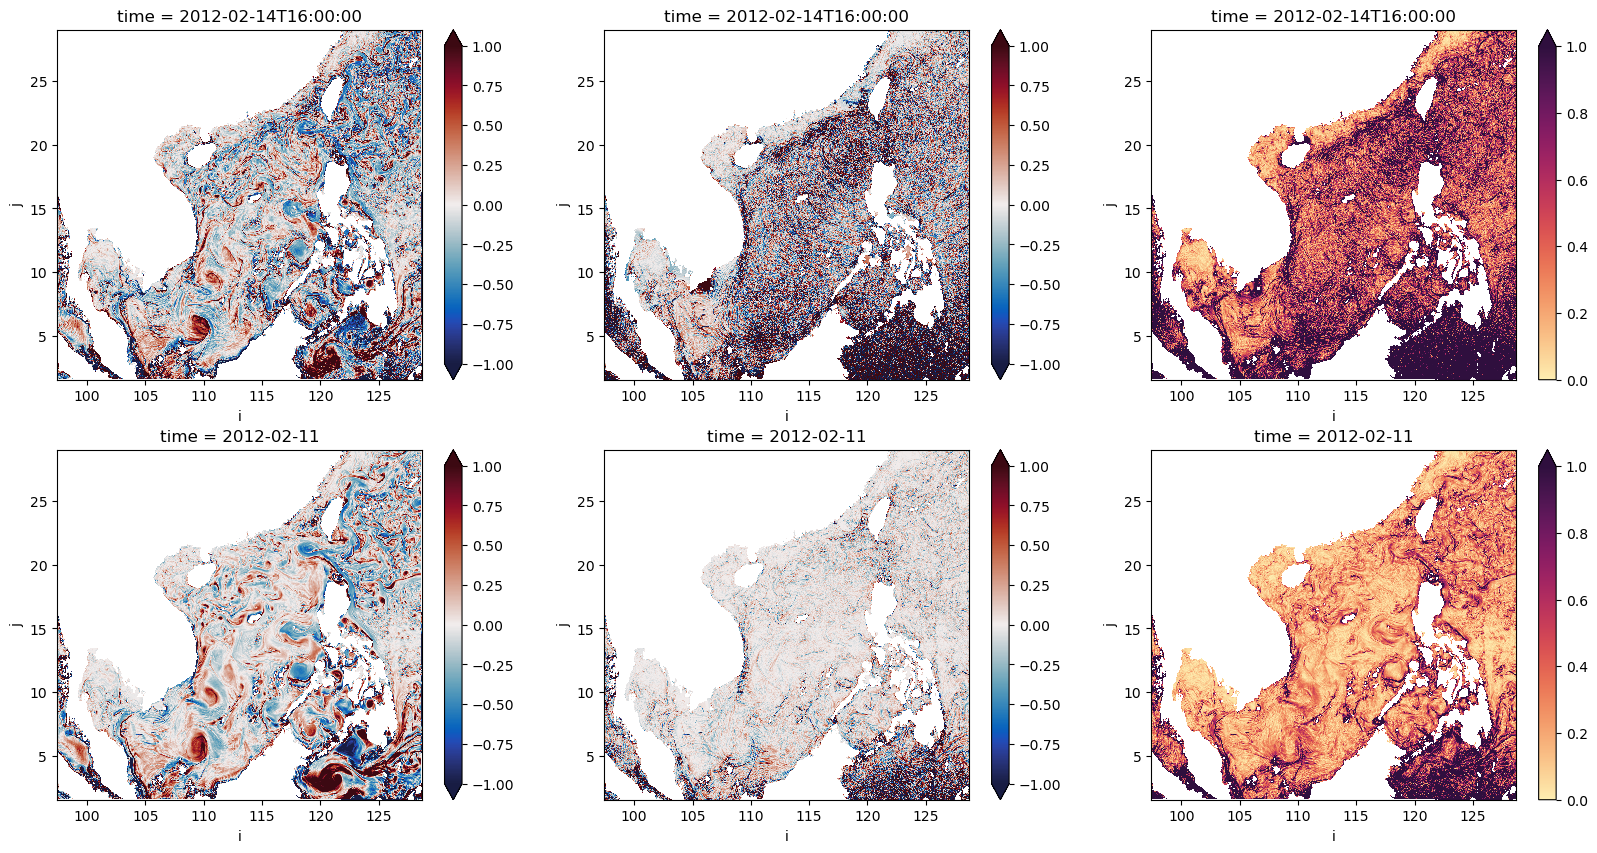

In [28]:
fig = plt.figure(figsize=(20,10))

plt.subplot(231)
zeta_f.isel(time=2000).plot(vmax=1,vmin=-1, cmap=cm.balance)

plt.subplot(232)
div_f.isel(time=2000).plot(vmax=1,vmin=-1, cmap=cm.balance)

plt.subplot(233)
strain_rate_f.isel(time=2000).plot(vmax=1,vmin=0, cmap=cm.matter)

plt.subplot(234)
zeta_f_daily.isel(time=80).plot(vmax=1,vmin=-1, cmap=cm.balance)

plt.subplot(235)
div_f_daily.isel(time=80).plot(vmax=1,vmin=-1, cmap=cm.balance)

plt.subplot(236)
strain_rate_f_daily.isel(time=80).plot(vmax=1,vmin=0, cmap=cm.matter)

____________________________________
## W (estimate from dEta/dt)

In [32]:
w = ( ds['Eta'].shift(time=-1) -  ds['Eta'] )/3600
w_daily = ( ds_daily['Eta'].shift(time=-1) -  ds_daily['Eta'] )/3600/24

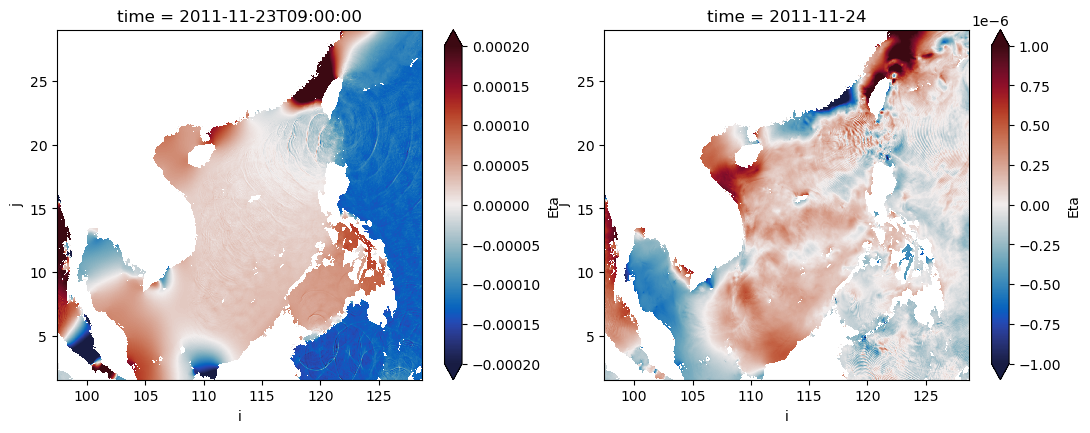

In [40]:
fig = plt.figure(figsize=(20,10))

plt.subplot(231)
w.isel(time=1).plot(vmax=2e-4,vmin=-2e-4, cmap=cm.balance)
plt.subplot(232)
w_daily.isel(time=1).plot(vmax=1e-6,vmin=-1e-6, cmap=cm.balance)

In [41]:
cluster.close()